# Training & Testing Menggunakan CUHK03 & Market-1501

Link Dataset

CUHK03
https://github.com/zhunzhong07/person-re-ranking/tree/master/CUHK03-NP

Market-1501
https://zheng-lab.cecs.anu.edu.au/Project/project_reid.html


# Training

### Data

In [ ]:
import os
import math
import copy
import shutil

import pandas as pd
import numpy as np

import time

from tempfile import TemporaryDirectory

import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
from torchvision import transforms, datasets
import torchvision
from torchvision.models import resnet18, ResNet18_Weights, resnet34, ResNet34_Weights, resnet50, ResNet50_Weights, resnext50_32x4d, ResNeXt50_32X4D_Weights
from torch.cuda.amp import GradScaler, autocast
from torchsummary import summary
from torch.autograd import Variable

# import skimage
from skimage.io import imread

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, average_precision_score

In [ ]:
dataset_path = "/content/Market-1501-v15.09.15/"
if os.path.exists(dataset_path):
    shutil.rmtree(dataset_path)

In [ ]:
dataset_path = "/content/cuhk03-np/"
if os.path.exists(dataset_path):
    shutil.rmtree(dataset_path)

In [ ]:
from google.colab import drive
import zipfile
import os

# Mount Google Drive
drive.mount('/content/drive')

# Path to the zip file in your Google Drive
zip_file_path = '/content/drive/My Drive/Semester 6/DL/project/Dataset/Market-1501-v15.09.15.zip'
zip_file_path2 = '/content/drive/My Drive/Semester 6/DL/project/Dataset/cuhk03-np.zip'

# Directory to extract the contents of the zip file
extracted_dir_path = '/content/'

# Create a directory if it doesn't exist
os.makedirs(extracted_dir_path, exist_ok=True)

# Unzip the file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extracted_dir_path)

with zipfile.ZipFile(zip_file_path2, 'r') as zip_ref:
    zip_ref.extractall(extracted_dir_path)

print("Zip file has been extracted successfully.")

# extracted_files = os.listdir(extracted_dir_path)

Mounted at /content/drive
Zip file has been extracted successfully.


In [ ]:
import os
from shutil import copyfile

# You only need to change this line to your dataset download path
download_path = '/content/Market-1501-v15.09.15'

if not os.path.isdir(download_path):
    print('please change the download_path')

save_path = download_path + '/pytorch'
if not os.path.isdir(save_path):
    os.mkdir(save_path)
#-----------------------------------------
#query
query_path = download_path + '/query'
query_save_path = download_path + '/pytorch/query'
if not os.path.isdir(query_save_path):
    os.mkdir(query_save_path)

for root, dirs, files in os.walk(query_path, topdown=True):
    for name in files:
        if not name[-3:]=='jpg':
            continue
        ID  = name.split('_')

        if ID[0] == '-1':
          continue

        src_path = query_path + '/' + name
        dst_path = query_save_path + '/' + ID[0]
        if not os.path.isdir(dst_path):
            os.mkdir(dst_path)
        copyfile(src_path, dst_path + '/' + name)

#-----------------------------------------
#multi-query
query_path = download_path + '/gt_bbox'
# for dukemtmc-reid, we do not need multi-query
if os.path.isdir(query_path):
    query_save_path = download_path + '/pytorch/multi-query'
    if not os.path.isdir(query_save_path):
        os.mkdir(query_save_path)

    for root, dirs, files in os.walk(query_path, topdown=True):
        for name in files:
            if not name[-3:]=='jpg':
                continue
            ID  = name.split('_')
            src_path = query_path + '/' + name
            dst_path = query_save_path + '/' + ID[0]
            if not os.path.isdir(dst_path):
                os.mkdir(dst_path)
            copyfile(src_path, dst_path + '/' + name)

#-----------------------------------------
#gallery
gallery_path = download_path + '/bounding_box_test'
gallery_save_path = download_path + '/pytorch/gallery'
if not os.path.isdir(gallery_save_path):
    os.mkdir(gallery_save_path)

for root, dirs, files in os.walk(gallery_path, topdown=True):
    for name in files:
        if not name[-3:]=='jpg':
            continue
        ID  = name.split('_')

        if ID[0] == '-1':
          continue

        src_path = gallery_path + '/' + name
        dst_path = gallery_save_path + '/' + ID[0]
        if not os.path.isdir(dst_path):
            os.mkdir(dst_path)
        copyfile(src_path, dst_path + '/' + name)

#---------------------------------------
#train_all
train_path = download_path + '/bounding_box_train'
train_save_path = download_path + '/pytorch/train_all'
if not os.path.isdir(train_save_path):
    os.mkdir(train_save_path)

for root, dirs, files in os.walk(train_path, topdown=True):
    for name in files:
        if not name[-3:]=='jpg':
            continue
        ID  = name.split('_')
        src_path = train_path + '/' + name
        dst_path = train_save_path + '/' + ID[0]
        if not os.path.isdir(dst_path):
            os.mkdir(dst_path)
        copyfile(src_path, dst_path + '/' + name)


#---------------------------------------
#train_val
train_path = download_path + '/bounding_box_train'
train_save_path = download_path + '/pytorch/train'
val_save_path = download_path + '/pytorch/val'
if not os.path.isdir(train_save_path):
    os.mkdir(train_save_path)
    os.mkdir(val_save_path)

for root, dirs, files in os.walk(train_path, topdown=True):
    for name in files:
        if not name[-3:]=='jpg':
            continue
        ID  = name.split('_')
        src_path = train_path + '/' + name
        dst_path = train_save_path + '/' + ID[0]
        if not os.path.isdir(dst_path):
            os.mkdir(dst_path)
            dst_path = val_save_path + '/' + ID[0]  #first image is used as val image
            os.mkdir(dst_path)
        copyfile(src_path, dst_path + '/' + name)

In [ ]:
import os
from shutil import copyfile

# You only need to change this line to your dataset download path
download_path = '/content/cuhk03-np/detected'

if not os.path.isdir(download_path):
    print('please change the download_path')

save_path = download_path + '/pytorch'
if not os.path.isdir(save_path):
    os.mkdir(save_path)

#-----------------------------------------
#query
query_path = download_path + '/query'
query_save_path = download_path + '/pytorch/query'
if not os.path.isdir(query_save_path):
    os.mkdir(query_save_path)

for root, dirs, files in os.walk(query_path, topdown=True):
    for name in files:
        if not name[-3:]=='png':
            continue
        ID  = name.split('_')
        src_path = query_path + '/' + name
        dst_path = query_save_path + '/' + ID[0]
        if not os.path.isdir(dst_path):
            os.mkdir(dst_path)
        copyfile(src_path, dst_path + '/' + name)

#---------------------------------------
#gallery
gallery_path = download_path + '/bounding_box_test'
gallery_save_path = download_path + '/pytorch/gallery'
if not os.path.isdir(gallery_save_path):
    os.mkdir(gallery_save_path)

for root, dirs, files in os.walk(gallery_path, topdown=True):
    for name in files:
        if not name[-3:]=='png':
            continue
        ID  = name.split('_')
        src_path = gallery_path + '/' + name
        dst_path = gallery_save_path + '/' + ID[0]
        if not os.path.isdir(dst_path):
            os.mkdir(dst_path)
        copyfile(src_path, dst_path + '/' + name)

#---------------------------------------
#train_all
train_path = download_path + '/bounding_box_train'
train_save_path = download_path + '/pytorch/train_all'
if not os.path.isdir(train_save_path):
    os.mkdir(train_save_path)

for root, dirs, files in os.walk(train_path, topdown=True):
    for name in files:
        if not name[-3:]=='png':
            continue
        ID  = name.split('_')
        src_path = train_path + '/' + name
        dst_path = train_save_path + '/' + ID[0]
        if not os.path.isdir(dst_path):
            os.mkdir(dst_path)
        copyfile(src_path, dst_path + '/' + name)

#---------------------------------------
#train_val
train_path = download_path + '/bounding_box_train'
train_save_path = download_path + '/pytorch/train'
val_save_path = download_path + '/pytorch/val'
if not os.path.isdir(train_save_path):
    os.mkdir(train_save_path)
    os.mkdir(val_save_path)

for root, dirs, files in os.walk(train_path, topdown=True):
    for name in files:
        if not name[-3:]=='png':
            continue
        ID  = name.split('_')
        src_path = train_path + '/' + name
        dst_path = train_save_path + '/' + ID[0]
        if not os.path.isdir(dst_path):
            os.mkdir(dst_path)
            dst_path = val_save_path + '/' + ID[0]  #first image is used as val image
            os.mkdir(dst_path)
        copyfile(src_path, dst_path + '/' + name)

In [ ]:
print(len(os.listdir("/content/Market-1501-v15.09.15/pytorch/train")))
print(len(os.listdir("/content/Market-1501-v15.09.15/pytorch/val")))
print(len(os.listdir("/content/Market-1501-v15.09.15/pytorch/gallery")))
print(len(os.listdir("/content/Market-1501-v15.09.15/pytorch/query")))

print(len(os.listdir("/content/cuhk03-np/detected/pytorch/train")))
print(len(os.listdir("/content/cuhk03-np/detected/pytorch/val")))
print(len(os.listdir("/content/cuhk03-np/detected/pytorch/gallery")))
print(len(os.listdir("/content/cuhk03-np/detected/pytorch/query")))

751
751
751
750
767
767
700
700


In [ ]:
# Untuk train-test split 50:50, bagian ini tidak dirun

def move_files(src_path, dst_path, val_save_path, split_percentage):
    if not os.path.isdir(dst_path):
        os.makedirs(dst_path)

    class_folders = os.listdir(src_path)
    num_classes = len(class_folders)

    num_train_classes = int(num_classes * split_percentage)
    train_classes = class_folders[:num_train_classes]

    for class_folder in train_classes:
        if class_folder == '-1':
            continue
        src_class_path = os.path.join(src_path, class_folder)
        dst_class_path = os.path.join(dst_path, class_folder)
        shutil.move(src_class_path, dst_class_path)

        src_image_path = os.path.join(dst_class_path, os.listdir(dst_class_path)[0])
        dst_val_class_path = os.path.join(val_save_path, class_folder)
        if not os.path.exists(dst_val_class_path):
            os.makedirs(dst_val_class_path)
        shutil.move(src_image_path, dst_val_class_path)

In [ ]:
# Untuk train-test split 50:50, bagian ini tidak dirun

def filter_query(src_path, reference_classes):
    query_folders = os.listdir(src_path)
    for query_folder in query_folders:
        if query_folder not in reference_classes:
            shutil.rmtree(os.path.join(src_path, query_folder))

In [ ]:
# Untuk train-test split 50:50, bagian ini tidak dirun

gallery_path = '/content/Market-1501-v15.09.15/pytorch/gallery'
query_path = '/content/Market-1501-v15.09.15/pytorch/query'
train_path = '/content/Market-1501-v15.09.15/pytorch/train'
val_path = '/content/Market-1501-v15.09.15/pytorch/val'

split_percentage = 0.6

move_files(gallery_path, train_path, val_path, split_percentage)

print(len(os.listdir("/content/Market-1501-v15.09.15/pytorch/train")))
print(len(os.listdir("/content/Market-1501-v15.09.15/pytorch/val")))
print(len(os.listdir("/content/Market-1501-v15.09.15/pytorch/gallery")))

reference_classes = os.listdir(gallery_path)
filter_query(query_path, reference_classes)
print(len(os.listdir("/content/Market-1501-v15.09.15/pytorch/query")))

1201
1201
301
301


In [ ]:
# Untuk train-test split 50:50, bagian ini tidak dirun

gallery_path = '/content/cuhk03-np/detected/pytorch/gallery'
query_path = '/content/cuhk03-np/detected/pytorch/query'
train_path = '/content/cuhk03-np/detected/pytorch/train'
val_path = '/content/cuhk03-np/detected/pytorch/val'

split_percentage = 0.58

move_files(gallery_path, train_path, val_path, split_percentage)

print(len(os.listdir("/content/cuhk03-np/detected/pytorch/train")))
print(len(os.listdir("/content/cuhk03-np/detected/pytorch/val")))
print(len(os.listdir("/content/cuhk03-np/detected/pytorch/gallery")))

reference_classes = os.listdir(gallery_path)
filter_query(query_path, reference_classes)
print(len(os.listdir("/content/cuhk03-np/detected/pytorch/query")))

1173
1173
294
294


In [ ]:
import os
from shutil import copy2
import shutil

def combine_datasets(dataset1_path, dataset2_path, combined_dataset_path):
    if not os.path.exists(combined_dataset_path):
        os.makedirs(combined_dataset_path)

    def copy_files_with_suffix(src_dir, dst_dir, suffix):
        if not os.path.exists(dst_dir):
            os.makedirs(dst_dir)
        for item in os.listdir(src_dir):
            src_item = os.path.join(src_dir, item)
            dst_item = os.path.join(dst_dir, f"{item}{suffix}")
            if os.path.isdir(src_item):
                copy_files_with_suffix(src_item, dst_item, suffix)
            else:
                if os.path.exists(dst_item):
                    base, extension = os.path.splitext(dst_item)
                    counter = 1
                    new_dst_item = f"{base}_{counter}{extension}"
                    while os.path.exists(new_dst_item):
                        counter += 1
                        new_dst_item = f"{base}_{counter}{extension}"
                    dst_item = new_dst_item
                copy2(src_item, dst_item)

    for class_name in os.listdir(dataset1_path):
        class_path1 = os.path.join(dataset1_path, class_name)
        combined_class_path = os.path.join(combined_dataset_path, f"{class_name}_1")
        copy_files_with_suffix(class_path1, combined_class_path, "")

    for class_name in os.listdir(dataset2_path):
        class_path2 = os.path.join(dataset2_path, class_name)
        combined_class_path = os.path.join(combined_dataset_path, f"{class_name}_2")
        copy_files_with_suffix(class_path2, combined_class_path, "")

In [ ]:
# Make sure the path for dataset 1 and 2 for train == val
dataset1_path = '/content/cuhk03-np/detected/pytorch/train'
dataset2_path = '/content/Market-1501-v15.09.15/pytorch/train'
combined_dataset_path = '/content/cuhk-1501/train'

if os.path.exists(combined_dataset_path):
    shutil.rmtree(combined_dataset_path)

combine_datasets(dataset1_path, dataset2_path, combined_dataset_path)

dataset1_path = '/content/cuhk03-np/detected/pytorch/val'
dataset2_path = '/content/Market-1501-v15.09.15/pytorch/val'
combined_dataset_path = '/content/cuhk-1501/val'

if os.path.exists(combined_dataset_path):
    shutil.rmtree(combined_dataset_path)

combine_datasets(dataset1_path, dataset2_path, combined_dataset_path)

print(len(os.listdir('/content/cuhk-1501/val')))
print(len(os.listdir('/content/cuhk-1501/train')))


2374
2374


In [ ]:
print(len(os.listdir('/content/cuhk-1501/train')))
print(len(os.listdir('/content/cuhk03-np/detected/pytorch/train')))
print(len(os.listdir('/content/Market-1501-v15.09.15/pytorch/train')))

2374
1173
1201


In [ ]:
h, w = 256, 128
data_dir = '/content/cuhk-1501/'
batchsize = 64
num_epochs = 1
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
transform_train_list = [
    transforms.Resize((h, w), interpolation=3),
    transforms.Pad(10),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
]

transform_val_list = [
    transforms.Resize(size=(h, w), interpolation=3),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
]

data_transforms = {
    'train': transforms.Compose(transform_train_list),
    'val': transforms.Compose(transform_val_list),
}

image_datasets = {}
image_datasets['train'] = datasets.ImageFolder(os.path.join(data_dir, 'train'),
                                               data_transforms['train'])
image_datasets['val'] = datasets.ImageFolder(os.path.join(data_dir, 'val'),
                                             data_transforms['val'])

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batchsize, shuffle=True, num_workers=4)
               for x in ['train', 'val']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes
print(len(class_names))

2374


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


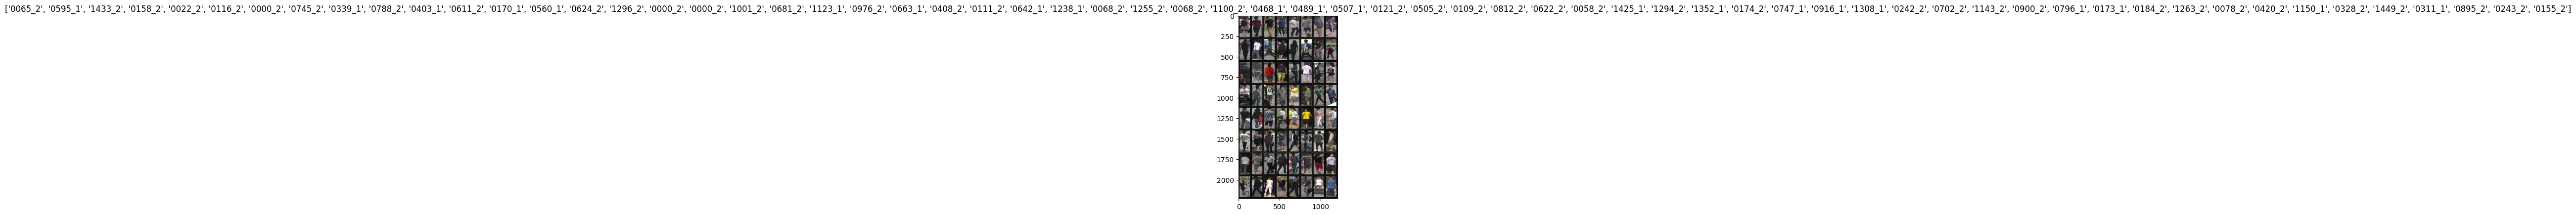

In [ ]:
def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [ ]:
def train_model(model, dataloaders, criterion, optimizer, scheduler, save_dir, save_train_name, save_best_name, num_epochs=25, start_epoch=0,):
    since = time.time()

    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    save_train = os.path.join(save_dir, save_train_name)
    save_best = os.path.join(save_dir, save_best_name)

    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0
        scaler = GradScaler()

        # Load the saved model parameters if resuming
        if start_epoch > 0:
          if os.path.exists(save_best):
            model.load_state_dict(torch.load(save_best))
          else:
            model.load_state_dict(torch.load(save_train))
          print(f"Resuming training from epoch {start_epoch}")

        for epoch in range(start_epoch, num_epochs):
            print(f'Epoch {epoch}/{num_epochs - 1}')
            print('-' * 10)

            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()  # Set model to training mode
                else:
                    model.eval()   # Set model to evaluate mode

                running_loss = 0.0
                running_corrects = 0

                # Iterate over data.
                for inputs, labels in dataloaders[phase]:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    # with torch.set_grad_enabled(phase == 'train'):
                    with autocast():
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            # loss.backward()
                            # optimizer.step()
                            scaler.scale(loss).backward()
                            scaler.step(optimizer)
                            scaler.update()

                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                if phase == 'train':
                    scheduler.step()

                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]

                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

                torch.save(model.state_dict(), save_train)

                # deep copy the model
                if phase == 'val' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), best_model_params_path)
                    torch.save(model.state_dict(), save_best)

            print()

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:4f}')

        # load best model weights
        model.load_state_dict(torch.load(best_model_params_path))
    return model

In [ ]:
def train_model_no_gs(model, dataloaders, criterion, optimizer, scheduler, save_dir, save_train_name, save_best_name, num_epochs=25, start_epoch=0,):
    since = time.time()

    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    save_train = os.path.join(save_dir, save_train_name)
    save_best = os.path.join(save_dir, save_best_name)

    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0
        # scaler = GradScaler()

        # Load the saved model parameters if resuming
        if start_epoch > 0:
          if os.path.exists(save_best):
            model.load_state_dict(torch.load(save_best))
          else:
            model.load_state_dict(torch.load(save_train))
          print(f"Resuming training from epoch {start_epoch}")

        for epoch in range(start_epoch, num_epochs):
            print(f'Epoch {epoch}/{num_epochs - 1}')
            print('-' * 10)

            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()  # Set model to training mode
                else:
                    model.eval()   # Set model to evaluate mode

                running_loss = 0.0
                running_corrects = 0

                # Iterate over data.
                for inputs, labels in dataloaders[phase]:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                    # with autocast():
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()
                            # scaler.scale(loss).backward()
                            # scaler.step(optimizer)
                            # scaler.update()

                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                if phase == 'train':
                    scheduler.step()

                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]

                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

                torch.save(model.state_dict(), save_train)

                # deep copy the model
                if phase == 'val' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), best_model_params_path)
                    torch.save(model.state_dict(), save_best)

            print()

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:4f}')

        # load best model weights
        model.load_state_dict(torch.load(best_model_params_path))
    return model

In [ ]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

### ResNet18

In [ ]:
modelResnet18_gs = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)

num_ftrs = modelResnet18_gs.fc.in_features
modelResnet18_gs.fc = nn.Linear(num_ftrs, len(class_names))
modelResnet18_gs.to(device)

modelResnet18_gs.eval()

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.AdamW(modelResnet18_gs.parameters(), lr=0.001)
# optimizer_ft = optim.AdamW(modelResnet18_gs.parameters(), lr=2e-4, weight_decay=0.015) # Fine-Tuned Parameter

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 87.0MB/s]


In [ ]:
save_dir = '/content/drive/My Drive/Semester 6/DL/project/Model/'
save_train = 'train_resnet18_combined.pt'
save_best = 'best_param_resnet18_combined.pt'

modelResnet18_gs = train_model(modelResnet18_gs, dataloaders, criterion, optimizer_ft, exp_lr_scheduler, save_dir, save_train, save_best, num_epochs=30)

Epoch 0/29
----------
train Loss: 6.8973 Acc: 0.0871
val Loss: 7.1648 Acc: 0.0046

Epoch 1/29
----------
train Loss: 5.1345 Acc: 0.1418
val Loss: 5.7835 Acc: 0.0577

Epoch 2/29
----------
train Loss: 3.3738 Acc: 0.3340
val Loss: 4.0073 Acc: 0.1997

Epoch 3/29
----------
train Loss: 1.8273 Acc: 0.5606
val Loss: 2.9889 Acc: 0.3387

Epoch 4/29
----------
train Loss: 0.9349 Acc: 0.7486
val Loss: 2.4504 Acc: 0.4461

Epoch 5/29
----------
train Loss: 0.5157 Acc: 0.8577
val Loss: 1.6813 Acc: 0.5910

Epoch 6/29
----------
train Loss: 0.2914 Acc: 0.9226
val Loss: 1.8665 Acc: 0.5644

Epoch 7/29
----------
train Loss: 0.0943 Acc: 0.9826
val Loss: 1.0127 Acc: 0.7468

Epoch 8/29
----------
train Loss: 0.0425 Acc: 0.9969
val Loss: 0.9672 Acc: 0.7565

Epoch 9/29
----------
train Loss: 0.0309 Acc: 0.9990
val Loss: 0.9842 Acc: 0.7616

Epoch 10/29
----------
train Loss: 0.0246 Acc: 0.9996
val Loss: 0.9262 Acc: 0.7662

Epoch 11/29
----------
train Loss: 0.0199 Acc: 0.9998
val Loss: 0.9439 Acc: 0.7700

Ep

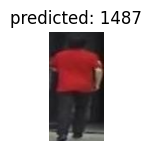

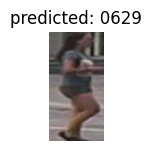

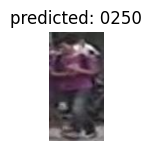

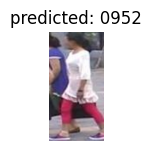

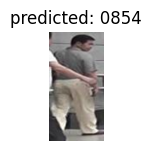

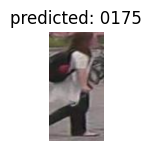

In [ ]:
visualize_model(modelResnet18_gs)

In [ ]:
modelResnet18_no_gs = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)

num_ftrs = modelResnet18_no_gs.fc.in_features
modelResnet18_no_gs.fc = nn.Linear(num_ftrs, len(class_names))
modelResnet18_no_gs.to(device)

modelResnet18_no_gs.eval()

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.AdamW(modelResnet18_no_gs.parameters(), lr=0.001)
# optimizer_ft = optim.AdamW(modelResnet18_no_gs.parameters(), lr=2e-4, weight_decay=0.015) # Fine-Tuned Parameter

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 171MB/s]


In [ ]:
save_dir = '/content/drive/My Drive/Semester 6/DL/project/Model/'
save_train = 'train_resnet18_combined_no_gs.pt'
save_best = 'best_param_resnet18_combined_no_gs.pt'

modelResnet18_no_gs = train_model_no_gs(modelResnet18_no_gs, dataloaders, criterion, optimizer_ft, exp_lr_scheduler, save_dir, save_train, save_best, num_epochs=30)

Epoch 0/29
----------
train Loss: 6.8494 Acc: 0.0874
val Loss: 7.0402 Acc: 0.0051

Epoch 1/29
----------
train Loss: 4.9523 Acc: 0.1535
val Loss: 5.5993 Acc: 0.0708

Epoch 2/29
----------
train Loss: 3.1802 Acc: 0.3569
val Loss: 3.9754 Acc: 0.2072

Epoch 3/29
----------
train Loss: 1.6918 Acc: 0.5874
val Loss: 2.5046 Acc: 0.4132

Epoch 4/29
----------
train Loss: 0.8669 Acc: 0.7669
val Loss: 2.2424 Acc: 0.4773

Epoch 5/29
----------
train Loss: 0.4743 Acc: 0.8705
val Loss: 1.9009 Acc: 0.5531

Epoch 6/29
----------
train Loss: 0.2751 Acc: 0.9267
val Loss: 2.1362 Acc: 0.5320

Epoch 7/29
----------
train Loss: 0.0870 Acc: 0.9843
val Loss: 1.0721 Acc: 0.7338

Epoch 8/29
----------
train Loss: 0.0377 Acc: 0.9979
val Loss: 1.0373 Acc: 0.7430

Epoch 9/29
----------
train Loss: 0.0278 Acc: 0.9990
val Loss: 1.0189 Acc: 0.7557

Epoch 10/29
----------
train Loss: 0.0218 Acc: 0.9994
val Loss: 0.9916 Acc: 0.7620

Epoch 11/29
----------
train Loss: 0.0178 Acc: 0.9997
val Loss: 0.9567 Acc: 0.7679

Ep

In [ ]:
# visualize_model(modelResnet18_no_gs)

### ResNet34

In [ ]:
modelResnet34_gs = resnet34(weights=ResNet34_Weights.IMAGENET1K_V1)

num_ftrs = modelResnet34_gs.fc.in_features
modelResnet34_gs.fc = nn.Linear(num_ftrs, len(class_names))
modelResnet34_gs.to(device)

modelResnet34_gs.eval()

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.AdamW(modelResnet34_gs.parameters(), lr=0.001)
# optimizer_ft = optim.AdamW(modelResnet34_gs.parameters(), lr=2e-4, weight_decay=0.015) # Fine-Tuned Parameter

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [ ]:
save_dir = '/content/drive/My Drive/Semester 6/DL/project/Model/'
save_train = 'train_resnet34_combined.pt'
save_best = 'best_param_resnet34_combined.pt'

modelResnet34_gs = train_model(modelResnet34_gs, dataloaders, criterion, optimizer_ft, exp_lr_scheduler, save_dir, save_train, save_best, num_epochs=30)

In [ ]:
# visualize_model(modelResnet34_gs)

In [ ]:
modelResnet34_no_gs = resnet34(weights=ResNet34_Weights.IMAGENET1K_V1)

num_ftrs = modelResnet34_no_gs.fc.in_features
modelResnet34_no_gs.fc = nn.Linear(num_ftrs, len(class_names))
modelResnet34_no_gs.to(device)

modelResnet34_no_gs.eval()

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.AdamW(modelResnet34_no_gs.parameters(), lr=0.001)
# optimizer_ft = optim.AdamW(modelResnet34_no_gs.parameters(), lr=2e-4, weight_decay=0.015) # Fine-Tuned Parameter

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [ ]:
save_dir = '/content/drive/My Drive/Semester 6/DL/project/Model/'
save_train = 'train_resnet34_combined_no_gs.pt'
save_best = 'best_param_resnet34_combined_no_gs.pt'

modelResnet34_no_gs = train_model_no_gs(modelResnet34_no_gs, dataloaders, criterion, optimizer_ft, exp_lr_scheduler, save_dir, save_train, save_best, num_epochs=30)

In [ ]:
# visualize_model(modelResnet34_no_gs)

### ResNet50

In [ ]:
modelResnet50_gs = resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)

num_ftrs = modelResnet50_gs.fc.in_features
modelResnet50_gs.fc = nn.Linear(num_ftrs, len(class_names))
modelResnet50_gs.to(device)

modelResnet50_gs.eval()

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.AdamW(modelResnet50_gs.parameters(), lr=0.001)
# optimizer_ft = optim.AdamW(modelResnet50_gs.parameters(), lr=2e-4, weight_decay=0.015) # Fine-Tuned Parameter

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 151MB/s]


In [ ]:
save_dir = '/content/drive/My Drive/Semester 6/DL/project/Model/'
save_train = 'train_resnet50_combined.pt'
save_best = 'best_param_resnet50_combined.pt'

modelResnet50_gs = train_model(modelResnet50_gs, dataloaders, criterion, optimizer_ft, exp_lr_scheduler, save_dir, save_train, save_best, num_epochs=30, start_epoch=29)

Resuming training from epoch 29
Epoch 29/29
----------
train Loss: 7.8280 Acc: 0.0118
val Loss: 6.8318 Acc: 0.0139

Training complete in 2m 51s
Best val Acc: 0.013901


In [ ]:
# visualize_model(modelResnet50_gs)

In [ ]:
modelResnet50_no_gs = resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)

num_ftrs = modelResnet50_no_gs.fc.in_features
modelResnet50_no_gs.fc = nn.Linear(num_ftrs, len(class_names))
modelResnet50_no_gs.to(device)

modelResnet50_no_gs.eval()

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.AdamW(modelResnet50_no_gs.parameters(), lr=0.001)
# optimizer_ft = optim.AdamW(modelResnet50_no_gs.parameters(), lr=2e-4, weight_decay=0.015) # Fine-Tuned Parameter

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [ ]:
save_dir = '/content/drive/My Drive/Semester 6/DL/project/Model/'
save_train = 'train_resnet50_combined_no_gs.pt'
save_best = 'best_param_resnet50_combined_no_gs.pt'

modelResnet50_no_gs = train_model(modelResnet50_no_gs, dataloaders, criterion, optimizer_ft, exp_lr_scheduler, save_dir, save_train, save_best, num_epochs=30)

Epoch 0/29
----------
train Loss: 7.2889 Acc: 0.0046
val Loss: 7.2699 Acc: 0.0025

Epoch 1/29
----------
train Loss: 6.0891 Acc: 0.0261
val Loss: 6.3350 Acc: 0.0211

Epoch 2/29
----------
train Loss: 4.6651 Acc: 0.1282
val Loss: 5.2045 Acc: 0.0805

Epoch 3/29
----------
train Loss: 3.0416 Acc: 0.3232
val Loss: 5.2961 Acc: 0.1398

Epoch 4/29
----------
train Loss: 1.8916 Acc: 0.5267
val Loss: 4.8601 Acc: 0.2051

Epoch 5/29
----------
train Loss: 1.1926 Acc: 0.6833
val Loss: 5.2799 Acc: 0.2216

Epoch 6/29
----------
train Loss: 0.7549 Acc: 0.7910
val Loss: 4.4921 Acc: 0.2978

Epoch 7/29
----------
train Loss: 0.2955 Acc: 0.9310
val Loss: 3.3884 Acc: 0.4090

Epoch 8/29
----------
train Loss: 0.1827 Acc: 0.9669
val Loss: 3.1831 Acc: 0.4356

Epoch 9/29
----------
train Loss: 0.1445 Acc: 0.9754
val Loss: 3.3263 Acc: 0.4288

Epoch 10/29
----------
train Loss: 0.1173 Acc: 0.9824
val Loss: 3.2241 Acc: 0.4457

Epoch 11/29
----------
train Loss: 0.0961 Acc: 0.9866
val Loss: 3.4260 Acc: 0.4410

Ep

In [ ]:
# visualize_model(modelResnet50_no_gs)

### ResNext50_32x4d

In [ ]:
modelResnext_gs = resnext50_32x4d(weights=ResNeXt50_32X4D_Weights.IMAGENET1K_V1)

num_ftrs = modelResnext_gs.fc.in_features
modelResnext_gs.fc = nn.Linear(num_ftrs, len(class_names))
modelResnext_gs.to(device)

modelResnext_gs.eval()

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.AdamW(modelResnext_gs.parameters(), lr=0.001)
# optimizer_ft = optim.AdamW(modelResnext_gs.parameters(), lr=2e-4, weight_decay=0.015) # Fine-Tuned Parameter

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnext50_32x4d-7cdf4587.pth" to /root/.cache/torch/hub/checkpoints/resnext50_32x4d-7cdf4587.pth
100%|██████████| 95.8M/95.8M [00:00<00:00, 168MB/s]


In [ ]:
# File for checkpoints
save_dir = '/content/drive/My Drive/Semester 6/DL/project/Model/'
save_train = 'train_resnext_combined.pt'
save_best = 'best_param_resnext_combined.pt'

modelResnext_gs = train_model(modelResnext_gs, dataloaders, criterion, optimizer_ft, exp_lr_scheduler, save_dir, save_train, save_best, num_epochs=30)

Epoch 0/29
----------
train Loss: 7.4716 Acc: 0.0032
val Loss: 7.2663 Acc: 0.0034

Epoch 1/29
----------
train Loss: 6.2513 Acc: 0.0215
val Loss: 6.5143 Acc: 0.0122

Epoch 2/29
----------
train Loss: 4.9674 Acc: 0.0924
val Loss: 5.5469 Acc: 0.0590

Epoch 3/29
----------
train Loss: 3.5069 Acc: 0.2566
val Loss: 4.3369 Acc: 0.1618

Epoch 4/29
----------
train Loss: 2.2011 Acc: 0.4640
val Loss: 3.1976 Acc: 0.3151

Epoch 5/29
----------
train Loss: 1.3082 Acc: 0.6463
val Loss: 2.7015 Acc: 0.4313

Epoch 6/29
----------
train Loss: 0.8335 Acc: 0.7649
val Loss: 2.6407 Acc: 0.4604

Epoch 7/29
----------
train Loss: 0.2881 Acc: 0.9285
val Loss: 1.5672 Acc: 0.6559

Epoch 8/29
----------
train Loss: 0.1578 Acc: 0.9708
val Loss: 1.4473 Acc: 0.6820

Epoch 9/29
----------
train Loss: 0.1181 Acc: 0.9831
val Loss: 1.4618 Acc: 0.6803

Epoch 10/29
----------
train Loss: 0.0906 Acc: 0.9889
val Loss: 1.4126 Acc: 0.6967

Epoch 11/29
----------
train Loss: 0.0694 Acc: 0.9937
val Loss: 1.4131 Acc: 0.6992

Ep

In [ ]:
# visualize_model(modelResnext_gs)

In [ ]:
modelResnext_no_gs = resnext50_32x4d(weights=ResNeXt50_32X4D_Weights.IMAGENET1K_V1)

num_ftrs = modelResnext_no_gs.fc.in_features
modelResnext_no_gs.fc = nn.Linear(num_ftrs, len(class_names))
modelResnext_no_gs.to(device)

modelResnext_no_gs.eval()

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.AdamW(modelResnext_no_gs.parameters(), lr=0.001)
# optimizer_ft = optim.AdamW(modelResnext_no_gs.parameters(), lr=2e-4, weight_decay=0.015) # Fine-Tuned Parameter

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [ ]:
# File for checkpoints
save_dir = '/content/drive/My Drive/Semester 6/DL/project/Model/'
save_train = 'train_resnext_combined_no_gs.pt'
save_best = 'best_param_resnext_combined_no_gs.pt'

modelResnext_no_gs = train_model(modelResnext_no_gs, dataloaders, criterion, optimizer_ft, exp_lr_scheduler, save_dir, save_train, save_best, num_epochs=30)

In [ ]:
# visualize_model(modelResnext_no_gs)

# Testing

### Prepare

In [ ]:
# Make sure the path for dataset 1 and 2 for train == val
dataset1_path = '/content/cuhk03-np/detected/pytorch/gallery'
dataset2_path = '/content/Market-1501-v15.09.15/pytorch/gallery'
combined_dataset_path = '/content/cuhk-1501/gallery'

if os.path.exists(combined_dataset_path):
    shutil.rmtree(combined_dataset_path)

combine_datasets(dataset1_path, dataset2_path, combined_dataset_path)

dataset1_path = '/content/cuhk03-np/detected/pytorch/query'
dataset2_path = '/content/Market-1501-v15.09.15/pytorch/query'
combined_dataset_path = '/content/cuhk-1501/query'

if os.path.exists(combined_dataset_path):
    shutil.rmtree(combined_dataset_path)

combine_datasets(dataset1_path, dataset2_path, combined_dataset_path)


In [ ]:
print(len(os.listdir('/content/cuhk-1501/gallery')))
print(len(os.listdir('/content/cuhk-1501/query')))
print(len(os.listdir('/content/cuhk03-np/detected/pytorch/gallery')))
print(len(os.listdir('/content/Market-1501-v15.09.15/pytorch/gallery')))

595
595
294
301


In [ ]:
transform_test_list = [
    transforms.Resize(size=(h, w), interpolation=3),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
]

data_transforms = {
    'gallery': transforms.Compose(transform_test_list),
    'query': transforms.Compose(transform_test_list),
}

image_datasets = {}
image_datasets['gallery'] = datasets.ImageFolder(os.path.join(data_dir, 'gallery'),
                                               data_transforms['gallery'])
image_datasets['query'] = datasets.ImageFolder(os.path.join(data_dir, 'query'),
                                             data_transforms['query'])

dataloaders_test = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batchsize, shuffle=False, num_workers=2, pin_memory=True)
               for x in ['gallery', 'query']}

dataset_test_sizes = {x: len(image_datasets[x]) for x in ['gallery', 'query']}
test_class_names = image_datasets['gallery'].classes
query_class_names = image_datasets['query'].classes
print(len(test_class_names))

595


In [ ]:
def process_in_batches(loader, model, device, batch_size=32):
    features = []
    labels = []
    with torch.no_grad():
        for imgs, lbls in loader:
            imgs = imgs.to(device)
            lbls = lbls.to(device)
            batch_features = []
            batch_labels = []
            for i in range(0, len(imgs), batch_size):
                batch_imgs = imgs[i:i+batch_size]
                batch_lbls = lbls[i:i+batch_size]
                batch_outputs = model(batch_imgs)
                batch_features.append(batch_outputs.cpu().numpy())
                batch_labels.append(batch_lbls.cpu().numpy())
            features.append(np.concatenate(batch_features))
            labels.append(np.concatenate(batch_labels))
    return np.concatenate(features), np.concatenate(labels)

In [ ]:
def compute_mAP_and_CMC(dist_matrix, query_labels, gallery_labels, query_cams, gallery_cams, max_rank=10):
  num_q, num_g = dist_matrix.shape

  indices = np.argsort(dist_matrix, axis=1)
  all_cmc = []
  all_AP = []
  all_INP = []
  num_valid_q = 0

  gallery_labels = np.array(gallery_labels)
  gallery_cams = np.array(gallery_cams)

  for q_idx in range(num_q):
    q_pid = query_labels[q_idx]
    q_camid = query_cams[q_idx]

    order = indices[q_idx]

    if (int(q_pid.split('_')[1])) == 2:
      remove = (gallery_labels[order] == q_pid) & (gallery_cams[order] == q_camid)
      keep = np.invert(remove)
      matches = (gallery_labels[order] == q_pid).astype(np.int32)
      raw_cmc = matches[keep]
      if not np.any(raw_cmc):
        continue

    else :
      raw_cmc = (gallery_labels[order] == q_pid).astype(int)

    cmc = raw_cmc.cumsum()

    pos_idx = np.where(raw_cmc == 1)[0]
    max_pos_idx = np.max(pos_idx)

    cmc[cmc > 1] = 1

    all_cmc.append(cmc[:max_rank])
    num_valid_q += 1.

    num_rel = raw_cmc.sum()
    tmp_cmc = raw_cmc.cumsum()
    tmp_cmc = [x / (i + 1.) for i, x in enumerate(tmp_cmc)]
    tmp_cmc = np.asarray(tmp_cmc) * raw_cmc
    AP = tmp_cmc.sum() / num_rel
    all_AP.append(AP)

  assert num_valid_q > 0, 'Error: all query identities do not appear in gallery'

  all_cmc = np.asarray(all_cmc).astype(np.float32)
  all_cmc = all_cmc.sum(0) / num_valid_q

  mAP = np.mean(all_AP)

  return mAP, all_cmc

In [ ]:
def compute_distance_matrix(query_features, gallery_features, batch_size=32):
    num_query = query_features.shape[0]
    num_gallery = gallery_features.shape[0]
    dist_matrix = np.zeros((num_query, num_gallery))

    for i in range(0, num_query, batch_size):
        query_batch = query_features[i:i+batch_size]
        for j in range(0, num_gallery, batch_size):
            gallery_batch = gallery_features[j:j+batch_size]
            query_gallery_dist = np.linalg.norm(query_batch[:, np.newaxis] - gallery_batch, axis=2)
            dist_matrix[i:i+len(query_batch), j:j+len(gallery_batch)] = query_gallery_dist

    return dist_matrix

In [ ]:
def predict(dist_matrix, gallery_class_names):
    predictions = []
    for dist in dist_matrix:
        pred_idx = np.argmin(dist)
        predictions.append(gallery_class_names[pred_idx])
    return predictions

In [ ]:
import re
def get_camera_id(filename):
    match = re.search(r'c(\d+)', filename)
    if match:
        return int(match.group(1))
    else:
        raise ValueError(f"Camera ID not found in filename: {filename}")

### ResNet18

In [ ]:
modelResnet18_gs = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
num_ftrs = modelResnet18_gs.fc.in_features
modelResnet18_gs.fc = nn.Linear(num_ftrs, len(class_names))
modelResnet18_gs.to(device)
modelResnet18_gs.eval()

modelResnet18_gs.load_state_dict(torch.load('/content/drive/My Drive/Semester 6/DL/project/Model/best_param_resnet18_combined.pt', map_location=device))
modelResnet18_gs.fc = torch.nn.Linear(num_ftrs, len(test_class_names))

for param_tensor in modelResnet18_gs.state_dict():
    modelResnet18_gs.state_dict()[param_tensor] = modelResnet18_gs.state_dict()[param_tensor].to(device)
modelResnet18_gs.fc.weight.data = modelResnet18_gs.fc.weight.data.to(device)
modelResnet18_gs.fc.bias.data = modelResnet18_gs.fc.bias.data.to(device)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 103MB/s]


In [ ]:
query_features, query_labels = process_in_batches(dataloaders_test['query'], modelResnet18_gs, device)
gallery_features, gallery_labels = process_in_batches(dataloaders_test['gallery'], modelResnet18_gs, device)

query_features = query_features / np.linalg.norm(query_features, axis=1, keepdims=True)
gallery_features = gallery_features / np.linalg.norm(gallery_features, axis=1, keepdims=True)

dist_matrix = compute_distance_matrix(query_features, gallery_features, batch_size=32)

query_cams = [get_camera_id(image_datasets['query'].imgs[i][0]) for i in range(len(query_labels))]
gallery_cams = [get_camera_id(image_datasets['gallery'].imgs[i][0]) for i in range(len(gallery_labels))]

query_class_names = [image_datasets['query'].classes[label] for label in query_labels]
gallery_class_names = [image_datasets['gallery'].classes[label] for label in gallery_labels]

In [ ]:
mAP, cmc = compute_mAP_and_CMC(dist_matrix, query_class_names, gallery_class_names, query_cams, gallery_cams)
predictions = predict(dist_matrix, gallery_class_names)

print(f'mAP: {mAP:.4f}')
print(f'CMC (top-1, top-5, top-10): {cmc[0]:.4f}, {cmc[4]:.4f}, {cmc[9]:.4f}')


mINP: 0.3196
mAP: 0.6598
CMC (top-1, top-5, top-10): 0.8548, 0.9499, 0.9719


In [ ]:
modelResnet18_no_gs = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
num_ftrs = modelResnet18_no_gs.fc.in_features
modelResnet18_no_gs.fc = nn.Linear(num_ftrs, len(class_names))
modelResnet18_no_gs.to(device)
modelResnet18_no_gs.eval()

modelResnet18_no_gs.load_state_dict(torch.load('/content/drive/My Drive/Semester 6/DL/project/Model/best_param_resnet18_combined_no_gs.pt', map_location=device))
modelResnet18_no_gs.fc = torch.nn.Linear(num_ftrs, len(test_class_names))

for param_tensor in modelResnet18_no_gs.state_dict():
    modelResnet18_no_gs.state_dict()[param_tensor] = modelResnet18_no_gs.state_dict()[param_tensor].to(device)
modelResnet18_no_gs.fc.weight.data = modelResnet18_no_gs.fc.weight.data.to(device)
modelResnet18_no_gs.fc.bias.data = modelResnet18_no_gs.fc.bias.data.to(device)

In [ ]:
query_features, query_labels = process_in_batches(dataloaders_test['query'], modelResnet18_no_gs, device)
gallery_features, gallery_labels = process_in_batches(dataloaders_test['gallery'], modelResnet18_no_gs, device)

query_features = query_features / np.linalg.norm(query_features, axis=1, keepdims=True)
gallery_features = gallery_features / np.linalg.norm(gallery_features, axis=1, keepdims=True)

dist_matrix = compute_distance_matrix(query_features, gallery_features, batch_size=32)

query_cams = [get_camera_id(image_datasets['query'].imgs[i][0]) for i in range(len(query_labels))]
gallery_cams = [get_camera_id(image_datasets['gallery'].imgs[i][0]) for i in range(len(gallery_labels))]

query_class_names = [image_datasets['query'].classes[label] for label in query_labels]
gallery_class_names = [image_datasets['gallery'].classes[label] for label in gallery_labels]

mAP, cmc = compute_mAP_and_CMC(dist_matrix, query_class_names, gallery_class_names, query_cams, gallery_cams)
predictions = predict(dist_matrix, gallery_class_names)

for i, (query_name, pred_name) in enumerate(zip(query_class_names, predictions)):
    print(f'Query {i+1}: {query_name}, Prediction: {pred_name}')

print(f'mAP: {mAP:.4f}')
print(f'CMC (top-1, top-5, top-10): {cmc[0]:.4f}, {cmc[4]:.4f}, {cmc[9]:.4f}')

Query 1: 0003_1, Prediction: 0003_1
Query 2: 0003_1, Prediction: 0003_1
Query 3: 0003_2, Prediction: 0003_2
Query 4: 0003_2, Prediction: 0003_2
Query 5: 0003_2, Prediction: 0003_2
Query 6: 0003_2, Prediction: 0003_2
Query 7: 0003_2, Prediction: 0003_2
Query 8: 0005_2, Prediction: 0005_2
Query 9: 0005_2, Prediction: 0005_2
Query 10: 0005_2, Prediction: 0005_2
Query 11: 0005_2, Prediction: 0005_2
Query 12: 0005_2, Prediction: 0005_2
Query 13: 0005_2, Prediction: 0005_2
Query 14: 0009_2, Prediction: 0009_2
Query 15: 0009_2, Prediction: 0009_2
Query 16: 0009_2, Prediction: 0009_2
Query 17: 0013_2, Prediction: 0013_2
Query 18: 0013_2, Prediction: 0013_2
Query 19: 0016_2, Prediction: 0016_2
Query 20: 0016_2, Prediction: 0016_2
Query 21: 0016_2, Prediction: 0016_2
Query 22: 0016_2, Prediction: 0016_2
Query 23: 0016_2, Prediction: 0016_2
Query 24: 0017_1, Prediction: 0017_1
Query 25: 0017_1, Prediction: 0017_1
Query 26: 0017_2, Prediction: 0017_2
Query 27: 0017_2, Prediction: 0017_2
Query 28: 

In [ ]:
print(f'mAP: {mAP:.4f}')
print(f'CMC (top-1, top-5, top-10): {cmc[0]:.4f}, {cmc[4]:.4f}, {cmc[9]:.4f}')


mINP: 0.2349
mAP: 0.5816
CMC (top-1, top-5, top-10): 0.8164, 0.9240, 0.9493


### ResNet34

In [ ]:
modelResnet34_gs = resnet34(weights=ResNet34_Weights.IMAGENET1K_V1)
num_ftrs = modelResnet34_gs.fc.in_features
modelResnet34_gs.fc = nn.Linear(num_ftrs, len(class_names))
modelResnet34_gs.to(device)
modelResnet34_gs.eval()

modelResnet34_gs.load_state_dict(torch.load('/content/drive/My Drive/Semester 6/DL/project/Model/best_param_resnet34_combined.pt', map_location=device))
modelResnet34_gs.fc = torch.nn.Linear(num_ftrs, len(test_class_names))

for param_tensor in modelResnet34_gs.state_dict():
    modelResnet34_gs.state_dict()[param_tensor] = modelResnet34_gs.state_dict()[param_tensor].to(device)
modelResnet34_gs.fc.weight.data = modelResnet34_gs.fc.weight.data.to(device)
modelResnet34_gs.fc.bias.data = modelResnet34_gs.fc.bias.data.to(device)

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 166MB/s]


In [ ]:
query_features, query_labels = process_in_batches(dataloaders_test['query'], modelResnet34_gs, device)
gallery_features, gallery_labels = process_in_batches(dataloaders_test['gallery'], modelResnet34_gs, device)

query_features = query_features / np.linalg.norm(query_features, axis=1, keepdims=True)
gallery_features = gallery_features / np.linalg.norm(gallery_features, axis=1, keepdims=True)

dist_matrix = compute_distance_matrix(query_features, gallery_features, batch_size=32)

query_cams = [get_camera_id(image_datasets['query'].imgs[i][0]) for i in range(len(query_labels))]
gallery_cams = [get_camera_id(image_datasets['gallery'].imgs[i][0]) for i in range(len(gallery_labels))]

query_class_names = [image_datasets['query'].classes[label] for label in query_labels]
gallery_class_names = [image_datasets['gallery'].classes[label] for label in gallery_labels]

mAP, cmc = compute_mAP_and_CMC(dist_matrix, query_class_names, gallery_class_names, query_cams, gallery_cams)
predictions = predict(dist_matrix, gallery_class_names)

for i, (query_name, pred_name) in enumerate(zip(query_class_names, predictions)):
    print(f'Query {i+1}: {query_name}, Prediction: {pred_name}')


Query 1: 0001_2, Prediction: 0001_2
Query 2: 0001_2, Prediction: 1160_2
Query 3: 0001_2, Prediction: 0001_2
Query 4: 0001_2, Prediction: 0001_2
Query 5: 0001_2, Prediction: 0001_2
Query 6: 0001_2, Prediction: 0001_2
Query 7: 0003_1, Prediction: 0003_1
Query 8: 0003_1, Prediction: 0003_1
Query 9: 0003_2, Prediction: 0003_2
Query 10: 0003_2, Prediction: 0003_2
Query 11: 0003_2, Prediction: 0003_2
Query 12: 0003_2, Prediction: 0003_2
Query 13: 0003_2, Prediction: 0003_2
Query 14: 0004_2, Prediction: 0004_2
Query 15: 0004_2, Prediction: 0004_2
Query 16: 0004_2, Prediction: 0004_2
Query 17: 0004_2, Prediction: 0004_2
Query 18: 0004_2, Prediction: 0004_2
Query 19: 0005_2, Prediction: 0005_2
Query 20: 0005_2, Prediction: 0005_2
Query 21: 0005_2, Prediction: 0005_2
Query 22: 0005_2, Prediction: 0005_2
Query 23: 0005_2, Prediction: 0005_2
Query 24: 0005_2, Prediction: 0005_2
Query 25: 0006_1, Prediction: 0006_1
Query 26: 0006_1, Prediction: 0006_1
Query 27: 0006_2, Prediction: 0006_2
Query 28: 

In [ ]:
print(f'mAP: {mAP:.4f}')
print(f'CMC (top-1, top-5, top-10): {cmc[0]:.4f}, {cmc[4]:.4f}, {cmc[9]:.4f}')


mAP: 0.0027
CMC (top-1, top-5, top-10): 0.0002, 0.0042, 0.0080


In [ ]:
modelResnet34_no_gs = resnet34(weights=ResNet34_Weights.IMAGENET1K_V1)
num_ftrs = modelResnet34_no_gs.fc.in_features
modelResnet34_no_gs.fc = nn.Linear(num_ftrs, len(class_names))
modelResnet34_no_gs.to(device)
modelResnet34_no_gs.eval()

modelResnet34_no_gs.load_state_dict(torch.load('/content/drive/My Drive/Semester 6/DL/project/Model/best_param_resnet34_combined_no_gs.pt', map_location=device))
modelResnet34_no_gs.fc = torch.nn.Linear(num_ftrs, len(test_class_names))

for param_tensor in modelResnet34_no_gs.state_dict():
    modelResnet34_no_gs.state_dict()[param_tensor] = modelResnet34_no_gs.state_dict()[param_tensor].to(device)
modelResnet34_no_gs.fc.weight.data = modelResnet34_no_gs.fc.weight.data.to(device)
modelResnet34_no_gs.fc.bias.data = modelResnet34_no_gs.fc.bias.data.to(device)

In [ ]:
query_features, query_labels = process_in_batches(dataloaders_test['query'], modelResnet34_no_gs, device)
gallery_features, gallery_labels = process_in_batches(dataloaders_test['gallery'], modelResnet34_no_gs, device)

query_features = query_features / np.linalg.norm(query_features, axis=1, keepdims=True)
gallery_features = gallery_features / np.linalg.norm(gallery_features, axis=1, keepdims=True)

dist_matrix = compute_distance_matrix(query_features, gallery_features, batch_size=32)

query_cams = [get_camera_id(image_datasets['query'].imgs[i][0]) for i in range(len(query_labels))]
gallery_cams = [get_camera_id(image_datasets['gallery'].imgs[i][0]) for i in range(len(gallery_labels))]

query_class_names = [image_datasets['query'].classes[label] for label in query_labels]
gallery_class_names = [image_datasets['gallery'].classes[label] for label in gallery_labels]

mAP, cmc = compute_mAP_and_CMC(dist_matrix, query_class_names, gallery_class_names, query_cams, gallery_cams)
predictions = predict(dist_matrix, gallery_class_names)

for i, (query_name, pred_name) in enumerate(zip(query_class_names, predictions)):
    print(f'Query {i+1}: {query_name}, Prediction: {pred_name}')


Query 1: 0001_2, Prediction: 0001_2
Query 2: 0001_2, Prediction: -1_2
Query 3: 0001_2, Prediction: 0001_2
Query 4: 0001_2, Prediction: 0001_2
Query 5: 0001_2, Prediction: 0001_2
Query 6: 0001_2, Prediction: 0001_2
Query 7: 0003_1, Prediction: 0003_1
Query 8: 0003_1, Prediction: 0003_1
Query 9: 0003_2, Prediction: 0003_2
Query 10: 0003_2, Prediction: 0003_2
Query 11: 0003_2, Prediction: 0003_2
Query 12: 0003_2, Prediction: 0003_2
Query 13: 0003_2, Prediction: 0003_2
Query 14: 0004_2, Prediction: 0004_2
Query 15: 0004_2, Prediction: 0004_2
Query 16: 0004_2, Prediction: 0004_2
Query 17: 0004_2, Prediction: 0004_2
Query 18: 0004_2, Prediction: 0004_2
Query 19: 0005_2, Prediction: 0005_2
Query 20: 0005_2, Prediction: 0005_2
Query 21: 0005_2, Prediction: 0005_2
Query 22: 0005_2, Prediction: 0005_2
Query 23: 0005_2, Prediction: 0005_2
Query 24: 0005_2, Prediction: 0005_2
Query 25: 0006_1, Prediction: 0006_1
Query 26: 0006_1, Prediction: 0006_1
Query 27: 0006_2, Prediction: 0006_2
Query 28: 00

In [ ]:
print(f'\nmAP: {mAP:.4f}')
print(f'CMC (top-1, top-5, top-10): {cmc[0]:.4f}, {cmc[4]:.4f}, {cmc[9]:.4f}')


mAP: 0.0025
CMC (top-1, top-5, top-10): 0.0004, 0.0029, 0.0071


### ResNet50

In [ ]:
modelResnet50_gs = resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)
num_ftrs = modelResnet50_gs.fc.in_features
modelResnet50_gs.fc = nn.Linear(num_ftrs, len(class_names))
modelResnet50_gs.to(device)
modelResnet50_gs.eval()

modelResnet50_gs.load_state_dict(torch.load('/content/drive/My Drive/Semester 6/DL/project/Model/best_param_resnet50_combined.pt', map_location=device))
modelResnet50_gs.fc = torch.nn.Linear(num_ftrs, len(test_class_names))

for param_tensor in modelResnet50_gs.state_dict():
    modelResnet50_gs.state_dict()[param_tensor] = modelResnet50_gs.state_dict()[param_tensor].to(device)
modelResnet50_gs.fc.weight.data = modelResnet50_gs.fc.weight.data.to(device)
modelResnet50_gs.fc.bias.data = modelResnet50_gs.fc.bias.data.to(device)

In [ ]:
query_features, query_labels = process_in_batches(dataloaders_test['query'], modelResnet50_gs, device)
gallery_features, gallery_labels = process_in_batches(dataloaders_test['gallery'], modelResnet50_gs, device)

query_features = query_features / np.linalg.norm(query_features, axis=1, keepdims=True)
gallery_features = gallery_features / np.linalg.norm(gallery_features, axis=1, keepdims=True)

dist_matrix = compute_distance_matrix(query_features, gallery_features, batch_size=32)

query_cams = [get_camera_id(image_datasets['query'].imgs[i][0]) for i in range(len(query_labels))]
gallery_cams = [get_camera_id(image_datasets['gallery'].imgs[i][0]) for i in range(len(gallery_labels))]

query_class_names = [image_datasets['query'].classes[label] for label in query_labels]
gallery_class_names = [image_datasets['gallery'].classes[label] for label in gallery_labels]

mAP, cmc = compute_mAP_and_CMC(dist_matrix, query_class_names, gallery_class_names, query_cams, gallery_cams)
predictions = predict(dist_matrix, gallery_class_names)

for i, (query_name, pred_name) in enumerate(zip(query_class_names, predictions)):
    print(f'Query {i+1}: {query_name}, Prediction: {pred_name}')

Query 1: 0001_2, Prediction: 1311_2
Query 2: 0001_2, Prediction: 1069_2
Query 3: 0001_2, Prediction: 0001_2
Query 4: 0001_2, Prediction: 1128_2
Query 5: 0001_2, Prediction: 0001_2
Query 6: 0001_2, Prediction: 0001_2
Query 7: 0004_2, Prediction: 0004_2
Query 8: 0004_2, Prediction: 0004_2
Query 9: 0004_2, Prediction: 0004_2
Query 10: 0004_2, Prediction: 0004_2
Query 11: 0004_2, Prediction: 0004_2
Query 12: 0006_1, Prediction: 0006_1
Query 13: 0006_1, Prediction: 0006_1
Query 14: 0006_2, Prediction: 0006_2
Query 15: 0006_2, Prediction: 0006_2
Query 16: 0006_2, Prediction: 0006_2
Query 17: 0006_2, Prediction: 0899_2
Query 18: 0006_2, Prediction: 0006_2
Query 19: 0009_2, Prediction: 0009_2
Query 20: 0009_2, Prediction: 0000_2
Query 21: 0009_2, Prediction: 0300_2
Query 22: 0011_1, Prediction: 0032_1
Query 23: 0011_1, Prediction: 0041_1
Query 24: 0016_2, Prediction: 0016_2
Query 25: 0016_2, Prediction: 0016_2
Query 26: 0016_2, Prediction: 0016_2
Query 27: 0016_2, Prediction: 0016_2
Query 28: 

In [ ]:
print(f'\nmAP: {mAP:.4f}')
print(f'CMC (top-1, top-5, top-10): {cmc[0]:.4f}, {cmc[4]:.4f}, {cmc[9]:.4f}')


mAP: 0.0980
CMC (top-1, top-5, top-10): 0.2105, 0.3935, 0.4842


In [ ]:
modelResnet50_no_gs = resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)
num_ftrs = modelResnet50_no_gs.fc.in_features
modelResnet50_no_gs.fc = nn.Linear(num_ftrs, len(class_names))
modelResnet50_no_gs.to(device)
modelResnet50_no_gs.eval()

modelResnet50_no_gs.load_state_dict(torch.load('/content/drive/My Drive/Semester 6/DL/project/Model/best_param_resnet50_combined_no_gs.pt', map_location=device))
modelResnet50_no_gs.fc = torch.nn.Linear(num_ftrs, len(test_class_names))

for param_tensor in modelResnet50_no_gs.state_dict():
    modelResnet50_no_gs.state_dict()[param_tensor] = modelResnet50_no_gs.state_dict()[param_tensor].to(device)
modelResnet50_no_gs.fc.weight.data = modelResnet50_no_gs.fc.weight.data.to(device)
modelResnet50_no_gs.fc.bias.data = modelResnet50_no_gs.fc.bias.data.to(device)

In [ ]:
query_features, query_labels = process_in_batches(dataloaders_test['query'], modelResnet50_no_gs, device)
gallery_features, gallery_labels = process_in_batches(dataloaders_test['gallery'], modelResnet50_no_gs, device)

query_features = query_features / np.linalg.norm(query_features, axis=1, keepdims=True)
gallery_features = gallery_features / np.linalg.norm(gallery_features, axis=1, keepdims=True)

dist_matrix = compute_distance_matrix(query_features, gallery_features, batch_size=32)

query_cams = [get_camera_id(image_datasets['query'].imgs[i][0]) for i in range(len(query_labels))]
gallery_cams = [get_camera_id(image_datasets['gallery'].imgs[i][0]) for i in range(len(gallery_labels))]

query_class_names = [image_datasets['query'].classes[label] for label in query_labels]
gallery_class_names = [image_datasets['gallery'].classes[label] for label in gallery_labels]

mAP, cmc = compute_mAP_and_CMC(dist_matrix, query_class_names, gallery_class_names, query_cams, gallery_cams)
predictions = predict(dist_matrix, gallery_class_names)

for i, (query_name, pred_name) in enumerate(zip(query_class_names, predictions)):
    print(f'Query {i+1}: {query_name}, Prediction: {pred_name}')


Query 1: 0001_2, Prediction: 0001_2
Query 2: 0001_2, Prediction: 0000_2
Query 3: 0001_2, Prediction: 0001_2
Query 4: 0001_2, Prediction: 0001_2
Query 5: 0001_2, Prediction: 0001_2
Query 6: 0001_2, Prediction: 0001_2
Query 7: 0004_2, Prediction: 0004_2
Query 8: 0004_2, Prediction: 0004_2
Query 9: 0004_2, Prediction: 0004_2
Query 10: 0004_2, Prediction: 0004_2
Query 11: 0004_2, Prediction: 0004_2
Query 12: 0006_1, Prediction: 0006_1
Query 13: 0006_1, Prediction: 0006_1
Query 14: 0006_2, Prediction: 0006_2
Query 15: 0006_2, Prediction: 0006_2
Query 16: 0006_2, Prediction: 0006_2
Query 17: 0006_2, Prediction: 0006_2
Query 18: 0006_2, Prediction: 0006_2
Query 19: 0009_2, Prediction: 0009_2
Query 20: 0009_2, Prediction: 0009_2
Query 21: 0009_2, Prediction: 0009_2
Query 22: 0011_1, Prediction: 0011_1
Query 23: 0011_1, Prediction: 0011_1
Query 24: 0016_2, Prediction: 0016_2
Query 25: 0016_2, Prediction: 0016_2
Query 26: 0016_2, Prediction: 0016_2
Query 27: 0016_2, Prediction: 0016_2
Query 28: 

In [ ]:
print(f'\nmAP: {mAP:.4f}')
print(f'CMC (top-1, top-5, top-10): {cmc[0]:.4f}, {cmc[4]:.4f}, {cmc[9]:.4f}')


mAP: 0.4373
CMC (top-1, top-5, top-10): 0.7081, 0.8559, 0.9082


### ResNext50_32x4d

In [ ]:
len(class_names)

2374

In [ ]:
modelResnext_gs = resnext50_32x4d(weights=ResNeXt50_32X4D_Weights.IMAGENET1K_V1)
num_ftrs = modelResnext_gs.fc.in_features
modelResnext_gs.fc = nn.Linear(num_ftrs, len(class_names))
modelResnext_gs.eval()
modelResnext_gs.to(device)

modelResnext_gs.load_state_dict(torch.load('/content/drive/My Drive/Semester 6/DL/project/Model/fine-tuned/best_param_resnext_combined.pt', map_location=device))
modelResnext_gs.fc = torch.nn.Linear(num_ftrs, len(test_class_names))

for param_tensor in modelResnext_gs.state_dict():
    modelResnext_gs.state_dict()[param_tensor] = modelResnext_gs.state_dict()[param_tensor].to(device)
modelResnext_gs.fc.weight.data = modelResnext_gs.fc.weight.data.to(device)
modelResnext_gs.fc.bias.data = modelResnext_gs.fc.bias.data.to(device)

Downloading: "https://download.pytorch.org/models/resnext50_32x4d-7cdf4587.pth" to /root/.cache/torch/hub/checkpoints/resnext50_32x4d-7cdf4587.pth
100%|██████████| 95.8M/95.8M [00:00<00:00, 130MB/s]


In [ ]:
query_features, query_labels = process_in_batches(dataloaders_test['query'], modelResnext_gs, device)
gallery_features, gallery_labels = process_in_batches(dataloaders_test['gallery'], modelResnext_gs, device)

query_features = query_features / np.linalg.norm(query_features, axis=1, keepdims=True)
gallery_features = gallery_features / np.linalg.norm(gallery_features, axis=1, keepdims=True)

dist_matrix = compute_distance_matrix(query_features, gallery_features, batch_size=32)

query_cams = [get_camera_id(image_datasets['query'].imgs[i][0]) for i in range(len(query_labels))]
gallery_cams = [get_camera_id(image_datasets['gallery'].imgs[i][0]) for i in range(len(gallery_labels))]

query_class_names = [image_datasets['query'].classes[label] for label in query_labels]
gallery_class_names = [image_datasets['gallery'].classes[label] for label in gallery_labels]

mAP, cmc = compute_mAP_and_CMC(dist_matrix, query_class_names, gallery_class_names, query_cams, gallery_cams)
predictions = predict(dist_matrix, gallery_class_names)

for i, (query_name, pred_name) in enumerate(zip(query_class_names, predictions)):
    print(f'Query {i+1}: {query_name}, Prediction: {pred_name}')


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


Query 1: 0001_2, Prediction: 0001_2
Query 2: 0001_2, Prediction: 0001_2
Query 3: 0001_2, Prediction: 0001_2
Query 4: 0001_2, Prediction: 0001_2
Query 5: 0001_2, Prediction: 0001_2
Query 6: 0001_2, Prediction: 0001_2
Query 7: 0004_2, Prediction: 0004_2
Query 8: 0004_2, Prediction: 0004_2
Query 9: 0004_2, Prediction: 0004_2
Query 10: 0004_2, Prediction: 0004_2
Query 11: 0004_2, Prediction: 0004_2
Query 12: 0005_2, Prediction: 0005_2
Query 13: 0005_2, Prediction: 0005_2
Query 14: 0005_2, Prediction: 0005_2
Query 15: 0005_2, Prediction: 0005_2
Query 16: 0005_2, Prediction: 0005_2
Query 17: 0005_2, Prediction: 0005_2
Query 18: 0006_1, Prediction: 0006_1
Query 19: 0006_1, Prediction: 0006_1
Query 20: 0006_2, Prediction: 0006_2
Query 21: 0006_2, Prediction: 0006_2
Query 22: 0006_2, Prediction: 0006_2
Query 23: 0006_2, Prediction: 0006_2
Query 24: 0006_2, Prediction: 0006_2
Query 25: 0008_2, Prediction: 0008_2
Query 26: 0008_2, Prediction: 0008_2
Query 27: 0008_2, Prediction: 0008_2
Query 28: 

In [ ]:
print(f'\nmAP: {mAP:.4f}')
print(f'CMC (top-1, top-5, top-10): {cmc[0]:.4f}, {cmc[4]:.4f}, {cmc[9]:.4f}')


mAP: 0.8636
CMC (top-1, top-5, top-10): 0.9488, 0.9840, 0.9896


In [ ]:
modelResnext_no_gs = resnext50_32x4d(weights=ResNeXt50_32X4D_Weights.IMAGENET1K_V1)
num_ftrs = modelResnext_no_gs.fc.in_features
modelResnext_no_gs.fc = nn.Linear(num_ftrs, len(class_names))
modelResnext_no_gs.eval()
modelResnext_no_gs.to(device)

modelResnext_no_gs.load_state_dict(torch.load('/content/drive/My Drive/Semester 6/DL/project/Model/fine-tuned/best_param_resnext_combined_no_gs.pt', map_location=device))
modelResnext_no_gs.fc = torch.nn.Linear(num_ftrs, len(test_class_names))

for param_tensor in modelResnext_no_gs.state_dict():
    modelResnext_no_gs.state_dict()[param_tensor] = modelResnext_no_gs.state_dict()[param_tensor].to(device)
modelResnext_no_gs.fc.weight.data = modelResnext_no_gs.fc.weight.data.to(device)
modelResnext_no_gs.fc.bias.data = modelResnext_no_gs.fc.bias.data.to(device)

In [ ]:
query_features, query_labels = process_in_batches(dataloaders_test['query'], modelResnext_no_gs, device)
gallery_features, gallery_labels = process_in_batches(dataloaders_test['gallery'], modelResnext_no_gs, device)

dist_matrix = compute_distance_matrix(query_features, gallery_features, batch_size=32)

query_class_names = [image_datasets['query'].classes[label] for label in query_labels]
gallery_class_names = [image_datasets['gallery'].classes[label] for label in gallery_labels]

mAP, cmc = compute_mAP_and_CMC(dist_matrix, query_class_names, gallery_class_names, query_cams, gallery_cams)
predictions = predict(dist_matrix, gallery_class_names)

for i, (query_name, pred_name) in enumerate(zip(query_class_names, predictions)):
    print(f'Query {i+1}: {query_name}, Prediction: {pred_name}')

Query 1: 0001_2, Prediction: 0001_2
Query 2: 0001_2, Prediction: 0351_2
Query 3: 0001_2, Prediction: 0001_2
Query 4: 0001_2, Prediction: 0001_2
Query 5: 0001_2, Prediction: 0001_2
Query 6: 0001_2, Prediction: 0001_2
Query 7: 0004_2, Prediction: 0004_2
Query 8: 0004_2, Prediction: 0004_2
Query 9: 0004_2, Prediction: 0004_2
Query 10: 0004_2, Prediction: 0004_2
Query 11: 0004_2, Prediction: 0004_2
Query 12: 0005_2, Prediction: 0005_2
Query 13: 0005_2, Prediction: 0005_2
Query 14: 0005_2, Prediction: 0005_2
Query 15: 0005_2, Prediction: 0005_2
Query 16: 0005_2, Prediction: 0005_2
Query 17: 0005_2, Prediction: 0005_2
Query 18: 0006_1, Prediction: 0006_1
Query 19: 0006_1, Prediction: 0006_1
Query 20: 0006_2, Prediction: 0006_2
Query 21: 0006_2, Prediction: 0006_2
Query 22: 0006_2, Prediction: 0006_2
Query 23: 0006_2, Prediction: 0006_2
Query 24: 0006_2, Prediction: 0006_2
Query 25: 0008_2, Prediction: 0008_2
Query 26: 0008_2, Prediction: 0008_2
Query 27: 0008_2, Prediction: 0008_2
Query 28: 

In [ ]:
print(f'\nmAP: {mAP:.4f}')
print(f'CMC (top-1, top-5, top-10): {cmc[0]:.4f}, {cmc[4]:.4f}, {cmc[9]:.4f}')


mAP: 0.8592
CMC (top-1, top-5, top-10): 0.9560, 0.9824, 0.9886
